In [1]:
import requests
from bs4 import BeautifulSoup
import time
import random

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re

# Data Collection

The recipe URLs from allrecipes.com for the categories 'dinner', 'vegetarian', and 'brunch' were obtained using the semi-interactive platform ParseHub and saved in csv files. Empty nutrient and ingredient dataframes were created with the appropriate columns, and passed into the web scraping function to be filled. The URLs were taken iteratively from the csv files. Once obtained, the nutrient and ingredient data was saved in csv format to be used for analysis.

The web scraping function was tested with two URLs so we verified that recipes were appended to the same dataframe.

The full code for data collection is located in the notebook Data_Collection.

In [2]:
# FUNCTION FOR WEB SCRAPING

def get_recipe_data(url, nutrient_df, ingredient_df):
    """
    Scrape allrecipes.com for information on the nutrient content and ingredients of each recipe
    Based on the url, ingredients and nutrient content are extracted separately from the website.
    
    IN: url: URL of the specific recipe as a string
    OUT: nutrient and ingredient dataframes with the information for the given recipe
    """
    
    #nutrition information
    url_nutrition = url + 'fullrecipenutrition'
    
    r1 = requests.get(url_nutrition)
    time.sleep(random.uniform(0,5))
    soup1 = BeautifulSoup(r1.text, 'html.parser')
    
    #this is the div containing all the nutrition information
    nutrition_info = soup1.find_all('div', class_='nutrition-row')
    
    nutrient_list = []
    
    recipe = soup1.find('h2')
    if recipe is not None:
        recipe = recipe.text
        for n in nutrition_info:
            name = n.find(class_ = 'nutrient-name').text
            amount = n.find(class_ = 'nutrient-value').text
            name = name[:name.index(':')]
            nutrient_list.append({'nutrient': name, 'amount': amount, 'recipe': recipe, 'URL': url})

    nutrients = pd.DataFrame(nutrient_list)
    nutrient_df = nutrient_df.append(nutrients, sort=True)
    
    #ingredients
    r2 = requests.get(url)
    time.sleep(random.uniform(0,5))
    soup2 = BeautifulSoup(r2.text, 'html.parser')
    ingredient_info = soup2.find_all(class_='recipe-container-outer')
    
    ingredient_list = []
    for i in ingredient_info:
        ingredient = i.find_all('span', {'itemprop':'recipeIngredient'}, class_ = 'recipe-ingred_txt added')
        for x in ingredient:
            ingredient_list.append({'ingredient': x.text, 'URL':url})

    ingredients = pd.DataFrame(ingredient_list)
    ingredient_df = ingredient_df.append(ingredients, sort=True)
    
    return nutrient_df, ingredient_df

# Data Analysis To Do List

**Cleaning:**
1. Make quantities of nutrients into integers (while respecting units)
2. Remove unnecessary columns
3. Create dataset with URL, recipe name, and ID for all recipes that have nutrient information

**Analysis:**
1. Create nutrient datasets for different types of meals: meat, fish, poultry, and vegetarian
2. Convert macronutrients (carbohydrates, fat, and protein) from grams to caloric values
3. Calculate the caloric percentage of each macronutrient to the total calories of the recipe
4. Compare these percentages with the recommended percentages for a healthy person with a 2000 calorie diet
5. Visualize histograms with quantities of vitamins and minerals for different recipe types to see if there are clear differences

**Visualization of results:**
1. Graphs showing the recommended percentage of macronutrients (out of total calories) and the actual percentages that appeared in the recipes for different types of meals
2. Histograms showing differences in nutrient quantities between meal types.

In [3]:
DATA_FOLDER = 'data'

In [4]:
dinner_nutrients_df = pd.read_csv('dinner_nutrient.csv')
dinner_ingredients_df = pd.read_csv('dinner_ingredient.csv')

brunch_nutrients_first = pd.read_csv('brunch_nutrient_1-120.csv')
brunch_nutrients_next = pd.read_csv('brunch_nutrient_121-524.csv')
brunch_ingredients_first = pd.read_csv('brunch_ingredient_1-120.csv')
brunch_ingredients_next = pd.read_csv('brunch_ingredient_121-524.csv')

vege_nutrients_df = pd.read_csv('vegetarian_nutrient.csv')
vege_ingredients_df = pd.read_csv('vegetarian_ingredient.csv')

## Lets explore the data and do some cleaning

In [5]:
dinner_nutrients_df.head(20)

,Unnamed: 0,URL,amount,nutrient,recipe
0,0,https://www.allrecipes.com/recipe/222607/smoth...,20.1g,Total Fat,Smothered Chicken Breasts
1,1,https://www.allrecipes.com/recipe/222607/smoth...,8.0g,Saturated Fat,Smothered Chicken Breasts
2,2,https://www.allrecipes.com/recipe/222607/smoth...,124mg,Cholesterol,Smothered Chicken Breasts
3,3,https://www.allrecipes.com/recipe/222607/smoth...,809mg,Sodium,Smothered Chicken Breasts
4,4,https://www.allrecipes.com/recipe/222607/smoth...,377mg,Potassium,Smothered Chicken Breasts
5,5,https://www.allrecipes.com/recipe/222607/smoth...,16.9g,Total Carbohydrates,Smothered Chicken Breasts
6,6,https://www.allrecipes.com/recipe/222607/smoth...,0.5g,Dietary Fiber,Smothered Chicken Breasts
7,7,https://www.allrecipes.com/recipe/222607/smoth...,44g,Protein,Smothered Chicken Breasts
8,8,https://www.allrecipes.com/recipe/222607/smoth...,15g,Sugars,Smothered Chicken Breasts
9,9,https://www.allrecipes.com/recipe/222607/smoth...,29IU,Vitamin A,Smothered Chicken Breasts


In [6]:
dinner_nutrients_df = dinner_nutrients_df.drop(["Unnamed: 0"], axis=1)
dinner_ingredients_df = dinner_ingredients_df.drop(["Unnamed: 0"], axis=1)

We wonder if the amounts for each nutrient always have the same units. Lets verify with Sodium since this is likely to vary a lot. Below only 'head' is displayed, but we checked throughout the dataset.

In [7]:
sodium = dinner_nutrients_df.where(dinner_nutrients_df['nutrient'] == "Sodium")
sodium = sodium.dropna()
sodium = sodium.reset_index(drop=True)
sodium.head()

,URL,amount,nutrient,recipe
0,https://www.allrecipes.com/recipe/222607/smoth...,809mg,Sodium,Smothered Chicken Breasts
1,https://www.allrecipes.com/recipe/15679/asian-...,711mg,Sodium,Asian Beef with Snow Peas
2,https://www.allrecipes.com/recipe/23847/pasta-...,350mg,Sodium,Pasta Pomodoro
3,https://www.allrecipes.com/recipe/50435/fry-br...,2255mg,Sodium,Fry Bread Tacos II
4,https://www.allrecipes.com/recipe/140829/pork-...,356mg,Sodium,Pork Marsala


The unit is the same for each value of a given nutrient, therefore we can drop these letters without worry.

In [8]:
#Remove the letters m, c, g, I, U from the string amount and convert it to a float
dinner_nutrients_df.amount = dinner_nutrients_df.amount.apply(lambda x: re.sub('[mcgIU]','', x))
dinner_nutrients_df.amount = dinner_nutrients_df.amount.replace(to_replace='< 1', value='0')
dinner_nutrients_df.amount = dinner_nutrients_df.amount.astype(float)
dinner_nutrients_df.dtypes

URL          object
amount      float64
nutrient     object
recipe       object
dtype: object

Now lets simplify the datasets

In [9]:
#We can identify recipes by their ID
recipe_id = dinner_ingredients_df["URL"].str.extract(r'https://www.allrecipes.com/recipe/(\d+)/.+')
dinner_ingredients_df["recipe_id"] = recipe_id
dinner_ingredients_df = dinner_ingredients_df.drop(["URL"], axis=1)
dinner_ingredients_df.head()

,ingredient,recipe_id
0,"4 (6 ounce) skinless, boneless chicken breast ...",222607
1,1/4 teaspoon salt,222607
2,1/4 teaspoon lemon pepper seasoning,222607
3,1 tablespoon vegetable oil,222607
4,8 strips bacon,222607


In [10]:
print("We have: " + str(len(dinner_ingredients_df["recipe_id"].unique())) + " recipes in the ingredient dataframe for dinner.")

We have: 1152 recipes in the ingredient dataframe for dinner.


In [11]:
recipe_id = dinner_nutrients_df["URL"].str.extract(r'https://www.allrecipes.com/recipe/(\d+)/.+')
dinner_nutrients_df["recipe_id"] = recipe_id

In [12]:
# let's create a dataframe that contain all the different recipes for dinner with the corresponding name and URL
dinner_recipe_df = dinner_nutrients_df[["recipe_id", "recipe", "URL"]].drop_duplicates()
print("We have in total: " + str(dinner_recipe_df["recipe"].count()) + " different recipes with nutrition info for dinner")
dinner_recipe_df.head()

We have in total: 1128 different recipes with nutrition info for dinner


,recipe_id,recipe,URL
0,222607,Smothered Chicken Breasts,https://www.allrecipes.com/recipe/222607/smoth...
18,15679,Asian Beef with Snow Peas,https://www.allrecipes.com/recipe/15679/asian-...
36,23847,Pasta Pomodoro,https://www.allrecipes.com/recipe/23847/pasta-...
54,50435,Fry Bread Tacos II,https://www.allrecipes.com/recipe/50435/fry-br...
72,140829,Pork Marsala,https://www.allrecipes.com/recipe/140829/pork-...


In [13]:
dinner_nutrients_df = dinner_nutrients_df.drop(["URL", "recipe"], axis=1)
dinner_nutrients_df.head()

,amount,nutrient,recipe_id
0,20.1,Total Fat,222607
1,8.0,Saturated Fat,222607
2,124.0,Cholesterol,222607
3,809.0,Sodium,222607
4,377.0,Potassium,222607


We see that there are recipes that did not give the nutrient values. We ignore these ones by putting exclusively recipe IDs present in the nutrient dataframe into the dataframe linking recipes with URL and name.

**Now we can clean our other datasets easily **

In [14]:
def clean_data(nutrients_df, ingredients_df):
    """
    After exploration, we create a general function to clean all subsequent datasets
    IN: nutrient and ingredient information, in dataframes
    OUT: cleaned nutrient and ingredient dataframes + a new dataframe linking the URL, ID, and name of recipes
    """
    
    nutrients_df = nutrients_df.drop(["Unnamed: 0"], axis=1)
    ingredients_df = ingredients_df.drop(["Unnamed: 0"], axis=1)
    
    #Remove the letters m, c, g, I, U from the string amount and convert it to a float
    nutrients_df.amount = nutrients_df.amount.apply(lambda x: re.sub('[mcgIU]','', x))
    nutrients_df.amount = nutrients_df.amount.replace(to_replace='< 1', value='0')
    nutrients_df.amount = nutrients_df.amount.astype(float)
    
    #Identification with ID
    recipe_id = ingredients_df["URL"].str.extract(r'https://www.allrecipes.com/recipe/(\d+)/.+')
    ingredients_df["recipe_id"] = recipe_id
    ingredients_df = ingredients_df.drop(["URL"], axis=1)
    
    recipe_id = nutrients_df["URL"].str.extract(r'https://www.allrecipes.com/recipe/(\d+)/.+')
    nutrients_df["recipe_id"] = recipe_id
    
    #Dataframe linking ID with URL and recipe name
    recipe_df = nutrients_df[["recipe_id", "recipe", "URL"]].drop_duplicates()
    
    nutrients_df = nutrients_df.drop(["URL", "recipe"], axis=1)
    
    return nutrients_df, ingredients_df, recipe_df

In [15]:
brunch_nutrients_df = brunch_nutrients_first.append(brunch_nutrients_next)
brunch_ingredients_df = brunch_ingredients_first.append(brunch_ingredients_next)
brunch_recipes = []

In [16]:
brunch_nutrients_df, brunch_ingredients_df, brunch_recipes = clean_data(brunch_nutrients_df, brunch_ingredients_df)

In [17]:
vege_recipes = []
vege_nutrients_df, vege_ingredients_df, vege_recipes = clean_data(vege_nutrients_df, vege_ingredients_df)

# Now we can analyse the data

## Create vegetarian, meat, poultry, and fish recipe datasets

Just having recipes is not representative of what people are eating since we cannot say how much they eat or how often. So we will instead compare the nutrient profiles of four meal types: vegetarian, meat dishes, fish dishes, and poultry dishes.

**Testing removing meat from "brunch" dishes:**

If an ingredient contains any word from the document "meats", delete all nutrients with the corresponding ID

In [18]:
f = open('data/meats', 'r')
meat = f.read().splitlines()
f.close()

In [19]:
brunch_copy = brunch_ingredients_df.copy()
#This merge is necessary to remove any recipes in the ingredients dataframe that don't have nutrition information
brunch_copy = brunch_copy.merge(brunch_recipes, left_on='recipe_id', right_on = 'recipe_id', how='inner', sort=False)

In [20]:
id_to_delete = pd.DataFrame(columns=['URL', 'ingredient', 'recipe', 'recipe_id'])

for i in range(len(meat)):
    id_to_delete = id_to_delete.append(brunch_copy[brunch_copy['ingredient'].str.contains(meat[i])], sort=False)

In [21]:
id_to_delete.head()

,URL,ingredient,recipe,recipe_id
303,https://www.allrecipes.com/recipe/22162/uglies/,1 pound ground beef chuck,Uglies,22162
1708,https://www.allrecipes.com/recipe/33129/corned...,"1 (12 ounce) can corned beef, cut into chunks",Corned Beef Hash,33129
1710,https://www.allrecipes.com/recipe/33129/corned...,1 cup beef broth,Corned Beef Hash,33129
2493,https://www.allrecipes.com/recipe/216981/delux...,"2 pounds cooked corned beef, cubed",Deluxe Corned Beef Hash,216981
3577,https://www.allrecipes.com/recipe/45652/the-sa...,2 pounds ground beef,The Sarge's Goetta - German Breakfast Treat,45652


In [22]:
brunch_nutrient_copy = brunch_nutrients_df.copy()
brunch_nutrient_copy=brunch_nutrient_copy[~brunch_nutrient_copy['recipe_id'].isin(id_to_delete['recipe_id'].tolist())]

In [23]:
#Test that the above function worked correctly:

In [24]:
test = brunch_nutrient_copy.where(brunch_nutrient_copy['recipe_id'] == '33129')
test = test.dropna()
test.head(1)

,amount,nutrient,recipe_id


In [25]:
nutrient_copy = brunch_nutrients_df.merge(brunch_recipes, how='inner', left_on='recipe_id', right_on='recipe_id')

In [26]:
val = nutrient_copy.where(nutrient_copy['recipe_id'] == '33129')
val = val.dropna()
val.head(1)

,amount,nutrient,recipe_id,recipe,URL
3564,8.8,Total Fat,33129,Corned Beef Hash,https://www.allrecipes.com/recipe/33129/corned...


**Finding that our test worked, we can now restrict meal types using the text files, with a generalized function**

In [27]:
def restrict_diet(nutrients_df, ingredients_df, recipes_df, filename, vegetarian=True):
    """
    For all words listed in the file, if that word is contained in ingredients_df, we take the recipe ID.
    If the desired result shall be vegetarian, all recipes with this ID are removed from the list of nutrients.
    If the desired result won't be vegetarian, then only recipes with this ID are kept in the list of nutrients.
    IN: ingredients, nutrients, and recipes, also the name of the file, and a boolean signifying if the result 
    should be vegetarian or not.
    OUT: nutrients from the restricted set of recipes.
    """
    
    f = open(filename, 'r')
    file = f.read().splitlines()
    f.close()
    
    #inner merge ingredients with recipes to associate them with recipe IDs that have nutrients
    ingredients_copy = ingredients_df.copy()
    ingredients_copy = ingredients_copy.merge(recipes_df, left_on='recipe_id', right_on='recipe_id', 
                                              how='inner', sort=False)
    
    #Create a dataframe of IDs, corresponding to recipes that contain words in the given file
    ids = pd.DataFrame(columns=['URL', 'ingredient', 'recipe', 'recipe_id'])
    for i in range(len(file)):
        ids = ids.append(ingredients_copy[ingredients_copy['ingredient'].str
                                                            .contains(file[i])], sort=False)
    
    nutrients_copy = nutrients_df.copy()
    
    if vegetarian:
        #The vegetarian recipes are those not listed in ids; we keep their nutrients
        nutrients_copy=nutrients_copy[~nutrients_copy.recipe_id.isin(ids['recipe_id'].tolist())]
    else:
        nutrients_copy = nutrients_copy[nutrients_copy.recipe_id.isin(ids['recipe_id'].tolist())]
    
    return nutrients_copy

In [28]:
#creation of large dataset containing all recipes we have

allrecipes_nutrients = pd.DataFrame(columns=['amount', 'nutrient', 'recipe_id'])
allrecipes_nutrients = allrecipes_nutrients.append(dinner_nutrients_df, ignore_index = True, sort = False)
allrecipes_nutrients = allrecipes_nutrients.append(brunch_nutrients_df, ignore_index = True, sort = False)
allrecipes_nutrients = allrecipes_nutrients.append(vege_nutrients_df, ignore_index = True, sort = False)

allrecipes_ingredients = pd.DataFrame(columns=['ingredient', 'recipe_id'])
allrecipes_ingredients = allrecipes_ingredients.append(dinner_ingredients_df, ignore_index = True, sort = False)
allrecipes_ingredients = allrecipes_ingredients.append(brunch_ingredients_df, ignore_index = True, sort = False)
allrecipes_ingredients = allrecipes_ingredients.append(vege_ingredients_df, ignore_index = True, sort = False)

allrecipes = pd.DataFrame(columns=['recipe_id', 'recipe', 'URL'])
allrecipes = allrecipes.append(dinner_recipe_df, ignore_index = True, sort = False)
allrecipes = allrecipes.append(brunch_recipes, ignore_index = True, sort = False)
allrecipes = allrecipes.append(vege_recipes, ignore_index = True, sort = False)

In [29]:
allrecipes.shape

(3110, 3)

In [30]:
#vegetarian meals
#the words from each file must be removed separately
temp_vege_nutrients = restrict_diet(allrecipes_nutrients, allrecipes_ingredients, allrecipes, 
                                          filename = 'data/meats')
temp_vege_nutrients = restrict_diet(temp_vege_nutrients, allrecipes_ingredients, allrecipes, 
                                     filename = 'data/fish')
vege_nutrients = restrict_diet(temp_vege_nutrients, allrecipes_ingredients, allrecipes, 
                                     filename = 'data/poultry')

In [31]:
#meat, fish, and poultry meals
meat_nutrients = restrict_diet(allrecipes_nutrients, allrecipes_ingredients, allrecipes, 
                                     filename = 'data/meats', vegetarian = False)
fish_nutrients = restrict_diet(allrecipes_nutrients, allrecipes_ingredients, allrecipes, 
                                     filename = 'data/fish', vegetarian = False)
poultry_nutrients = restrict_diet(allrecipes_nutrients, allrecipes_ingredients, allrecipes, 
                                     filename = 'data/poultry', vegetarian = False)

In [32]:
#number of recipes in each meal type
print(len(meat_nutrients['recipe_id'].unique()))
print(len(fish_nutrients.recipe_id.unique()))
print(len(poultry_nutrients.recipe_id.unique()))
print(len(vege_nutrients.recipe_id.unique()))

836
597
455
1502


## Convert macronutrients to calories
We want to calculate macronutrients as % total calories, as we have recommended percentages as Dietary Reference Intakes, which are acceptable macronutrient distribution ranges from this [page](https://www.ncbi.nlm.nih.gov/books/NBK56068/table/summarytables.t5/?report=objectonly).

We can convert total fat grams to kilocalories by the following calculation: (Total Fat in grams * 9)

We can convert carbohydrates: (Carbohydrates in grams * 4)

We can convert Protein: (Protein in grams * 4)

Only these three macronutrinets contribute in any significant way to the total calories of a recipe, so the total calories can be calculated by adding them. Knowing the total calories of the recipe, it is easy to calculate what percentage of this total is due to each of the three macronutrients above: 100 * calories of macronutrient / total calories.

In [33]:
def percent_total_kcal(nutrients_df):
    """
    Calculate amounts of fat, carbohydrates, and protein as %total calories in the recipe
    IN: dataframe with nutrient amounts and total energy content in kcal
    OUT: dataframe with nutrient amounts as %total energy content
    """
    nutrients_df['fat_kcal'] = 100 * nutrients_df['fat_kcal']/nutrients_df['total_kcal']
    nutrients_df['carbohydrates_kcal'] = 100 * nutrients_df['carbohydrates_kcal']/nutrients_df['total_kcal']
    nutrients_df['protein_kcal'] = 100 * nutrients_df['protein_kcal']/nutrients_df['total_kcal']
    nutrients_df.drop(columns='total_kcal', inplace=True)
    
    return nutrients_df

In [34]:
def calories(nutrients_df):
    """
    Convert amounts (in grams) for Total Fat, Carbohydrates, and Protein into kilocalories
    IN: dataframe with nutrients and corresponding amounts
    OUT: dataframe with the recipe id as index and columns containing the amounts in kilocalories for fat, protein,
    carbohydrates, and the total caloric content of the recipe
    """
    calorie_df = pd.DataFrame()
    
    fat_df = nutrients_df.where(nutrients_df.nutrient == 'Total Fat')
    fat_df = fat_df.dropna()
    fat_df['amount'] = fat_df['amount'] * 9
    fat_df = fat_df.set_index(fat_df['recipe_id'], drop=False)
    calorie_df['fat_kcal'] = fat_df['amount']
    
    carb_df = nutrients_df.where(nutrients_df.nutrient == 'Total Carbohydrates')
    carb_df = carb_df.dropna()
    carb_df['amount'] = carb_df['amount'] * 4
    carb_df = carb_df.set_index(carb_df['recipe_id'], drop=False)
    calorie_df['carbohydrates_kcal'] = carb_df['amount']
    
    prot_df = nutrients_df.where(nutrients_df.nutrient == 'Protein')
    prot_df = prot_df.dropna()
    prot_df['amount'] = prot_df['amount'] * 4
    prot_df = prot_df.set_index(prot_df['recipe_id'], drop=False)
    calorie_df['protein_kcal'] = prot_df['amount']
    
    total_kcal = fat_df['amount'] + prot_df['amount'] + carb_df['amount']
    calorie_df['total_kcal'] = total_kcal
    
    percent_calorie_df = percent_total_kcal(calorie_df)
    
    return percent_calorie_df

In [35]:
vege_kcal_nutrients = calories(vege_nutrients)
vege_kcal_nutrients.head(3)

,fat_kcal,carbohydrates_kcal,protein_kcal
recipe_id,,,
16066,51.360462,4.719480,43.920058
16427,46.440235,2.090137,51.469628
13941,53.714982,25.497361,20.787657


In [36]:
meat_kcal_nutrients = calories(meat_nutrients)
fish_kcal_nutrients = calories(fish_nutrients)
poultry_kcal_nutrients = calories(poultry_nutrients)

### Histograms of %total calories for macronutrients

Each macronutrient, given as a percentage of the total calories of recipes, is plotted on a histogram. Each meal type is given its own color, and the height of the bars are normalized so we can compare meal types that have different numbers of recipes.

In [37]:
def kcal_histogram(kcal_category, handle):
    """
    Define the histograms for the category chosen.
    IN: fat_kcal or carbohydrates_kcal or protein_kcal, name of the category in a user legible fashion
    OUT: histogram of the distrubution of % of total category originating from the chosen kcal category, classified
    from the recipes in the 4 meals category
    """
    plt.figure(figsize=(16,6));
    ax = plt.gca();
     
    graph = plt.hist([vege_kcal_nutrients[kcal_category], meat_kcal_nutrients[kcal_category], 
                     fish_kcal_nutrients[kcal_category], poultry_kcal_nutrients[kcal_category]], 
                     bins=20, color= ['green','red','blue','orange'], 
                     label=['vegetarian', 'meat', 'fish', 'poultry'], density=True);
    
    plt.xlabel(handle + ' [% total kcal]');
    plt.ylabel('Percentage of recipes');
    plt.legend(loc='upper right');
    ax.grid(zorder=0);
    y_vals = ax.get_yticks();
    ax.set_yticklabels(['{:3.1f}'.format(x * 100) for x in y_vals]);
    plt.xlim([0,100])
    plt.title(handle + ' in recipes as percent of total calories');
    return graph;

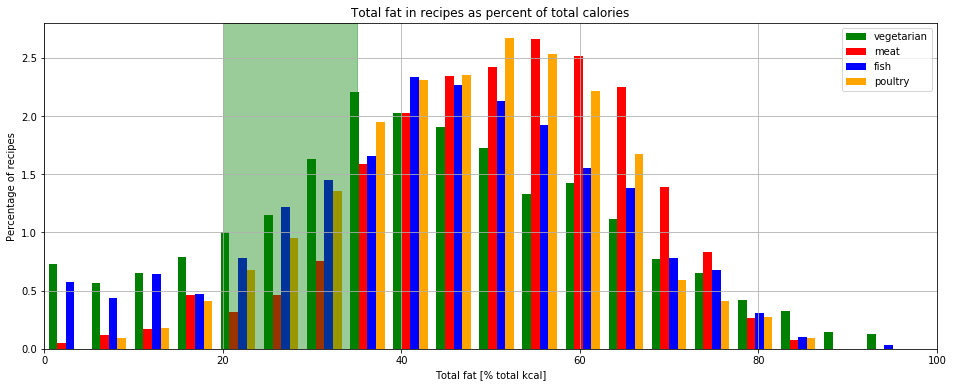

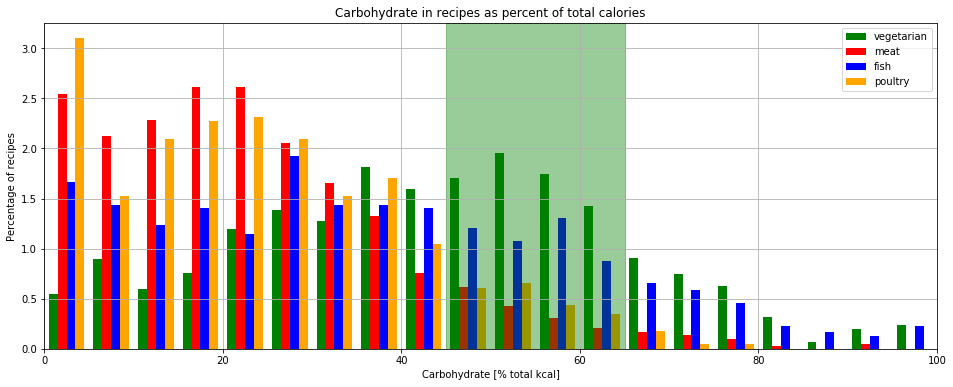

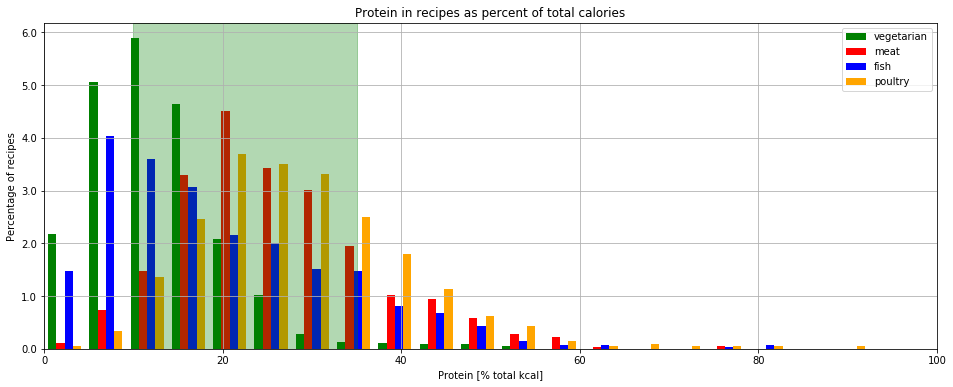

In [38]:
TotalFatHist = kcal_histogram(kcal_category='fat_kcal', handle ='Total fat');
plt.axvspan(20, 35, alpha=0.4, color='green');
plt.savefig('graphs/totalFatHist')
CarbohydrateHist = kcal_histogram(kcal_category='carbohydrates_kcal', handle='Carbohydrate');
plt.axvspan(45, 65, alpha=0.4, color='green');
plt.savefig('graphs/carbohydratesHist')
ProteinHist = kcal_histogram(kcal_category='protein_kcal', handle='Protein');
plt.axvspan(10,35, alpha=0.3, color='green');
plt.savefig('graphs/proteinHist')

# Nutrient profile histograms

Histogram distributions for nutrient profiles, for different meal types, normalized for number of recipes.

In [39]:
vege_nutrients['amount'].quantile(0.99)

vege_nutrients_filter = vege_nutrients.loc[vege_nutrients.amount < vege_nutrients['amount'].quantile(0.99)]
meat_nutrients_filter = meat_nutrients.loc[meat_nutrients.amount < meat_nutrients['amount'].quantile(0.99)]
fish_nutrients_filter = fish_nutrients.loc[fish_nutrients.amount < fish_nutrients['amount'].quantile(0.99)]
poultry_nutrients_filter = poultry_nutrients.loc[poultry_nutrients.amount < poultry_nutrients['amount']
                                                 .quantile(0.99)]

The above code takes the quantiles over the amounts for all nutrients. Therefore values that are very extreme over the whole set are removed, improving the Sodium and Vitamin A graphs that had extreme values, but a better algorithm would calculate the quantile for each nutrient.

In [40]:
nutrients_dfs = [vege_nutrients_filter, meat_nutrients_filter, fish_nutrients_filter, poultry_nutrients_filter]

def nutrients_histograms(nutrientName, unit, nutrients_dfs):
    """
    Create histogram for the given nutrient, for all given meal types.
    Also show the median value for each meal type.
    IN: name of the nutrient, its unit, and list of meal types in the format 'vegetarian', 'meat', 'fish', 'poultry'
    OUT: histograms showing the distribution of the nutrient for each meal type, and its median
    """
    
    
    plt.figure(figsize=(16,6));
    ax = plt.gca();
    
    
    vege_nutrient = nutrients_dfs[0].where(nutrients_dfs[0]['nutrient'] == nutrientName).dropna().reset_index(drop=True);
    vege_median = vege_nutrient.amount.median()
    meat_nutrient = nutrients_dfs[1].where(nutrients_dfs[1]['nutrient'] == nutrientName).dropna().reset_index(drop=True);
    meat_median = meat_nutrient.amount.median()
    fish_nutrient = nutrients_dfs[2].where(nutrients_dfs[2]['nutrient'] == nutrientName).dropna().reset_index(drop=True);
    fish_median = fish_nutrient.amount.median()
    poultry_nutrient = nutrients_dfs[3].where(nutrients_dfs[3]['nutrient'] == nutrientName).dropna().reset_index(drop=True);
    poultry_median = poultry_nutrient.amount.median()
    graph = plt.hist([vege_nutrient['amount'], meat_nutrient['amount'], fish_nutrient['amount'], 
                      poultry_nutrient['amount']], bins=20, color= ['green','red','blue','orange'], 
                     label=['vegetarian', 'meat', 'fish', 'poultry'], density=True);
    
    plt.title(nutrientName);

    plt.axvline(vege_median, color='green', linestyle='dashed', linewidth=1)
    plt.axvline(meat_median, color='red', linestyle='dashed', linewidth=1)
    plt.axvline(fish_median, color='blue', linestyle='dashed', linewidth=1)
    plt.axvline(poultry_median, color='orange', linestyle='dashed', linewidth=1)
    
    ax.grid(zorder=0);
    y_vals = ax.get_yticks();
    ax.set_yticklabels(['{:3.1f}'.format(x * 100) for x in y_vals]);
    plt.legend(loc='upper right');
    plt.xlabel('Quantity of nutrient in '+ str(unit));
    plt.ylabel('Percentage of recipes');
    filename = str('graphs/' + nutrientName + 'Hist')
    plt.savefig(filename)
    return graph

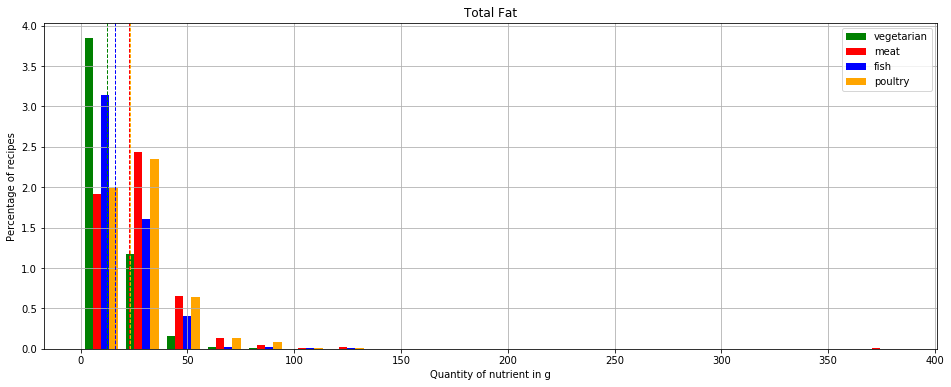

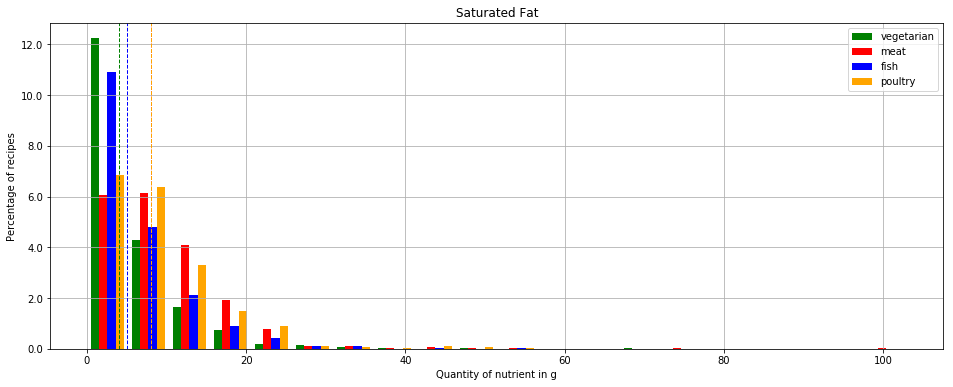

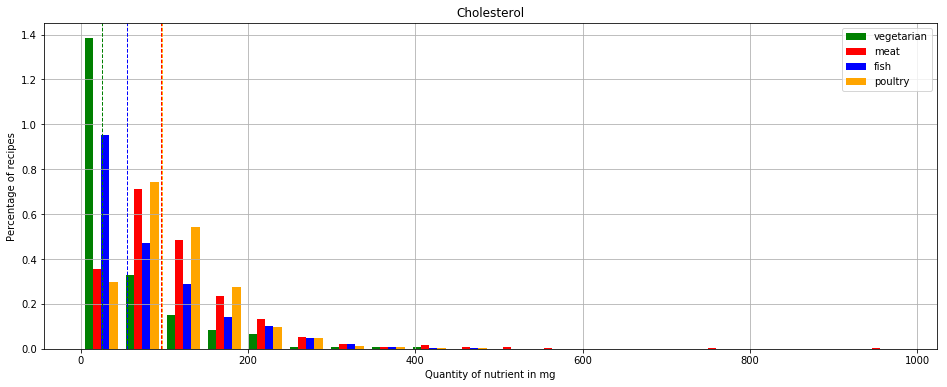

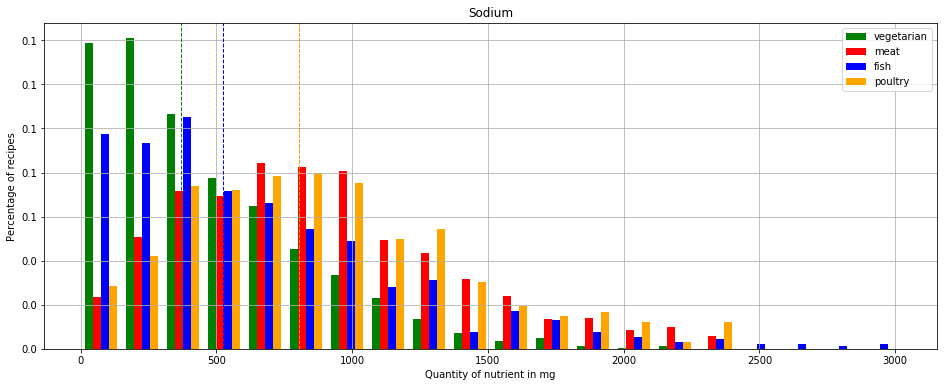

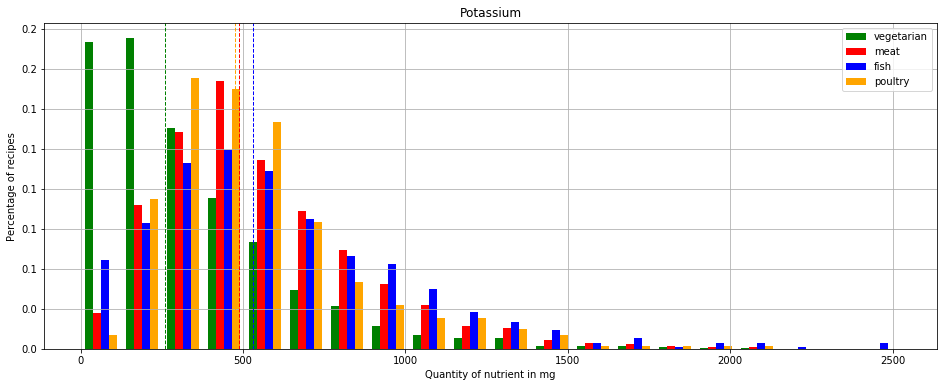

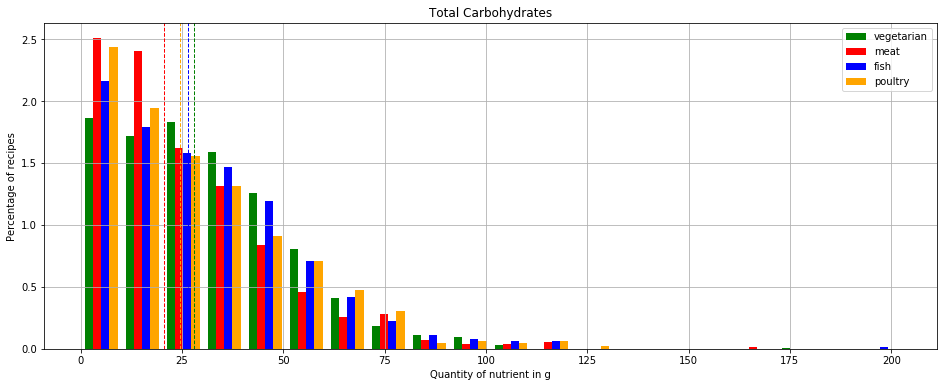

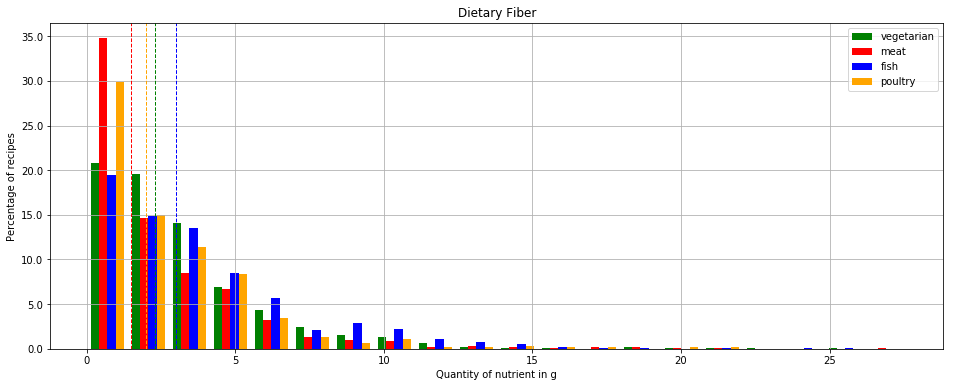

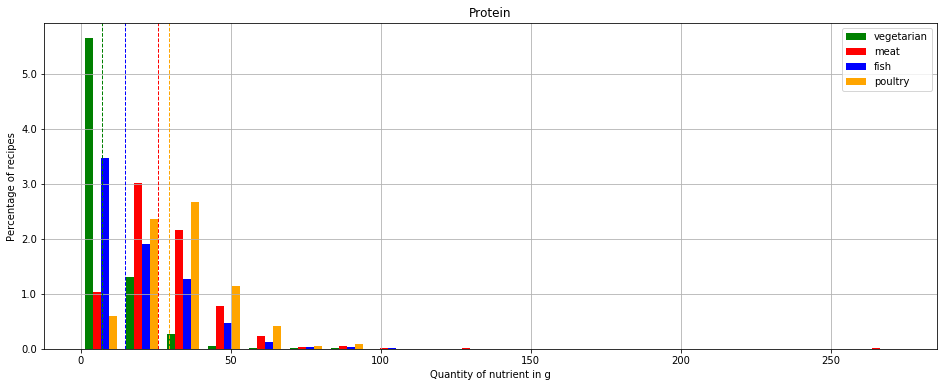

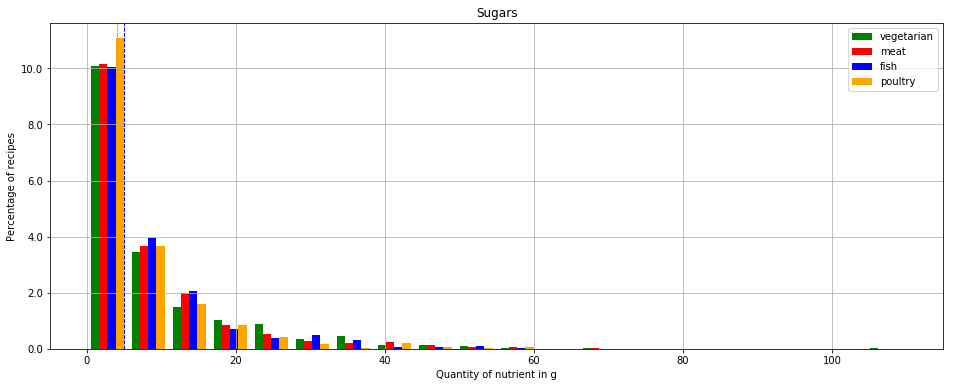

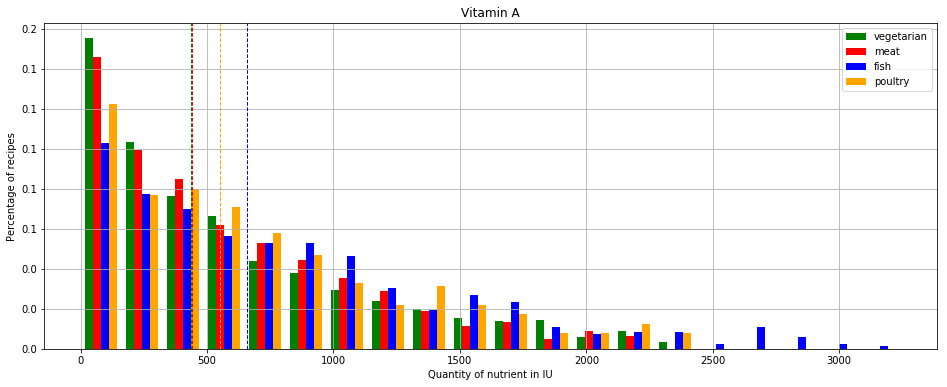

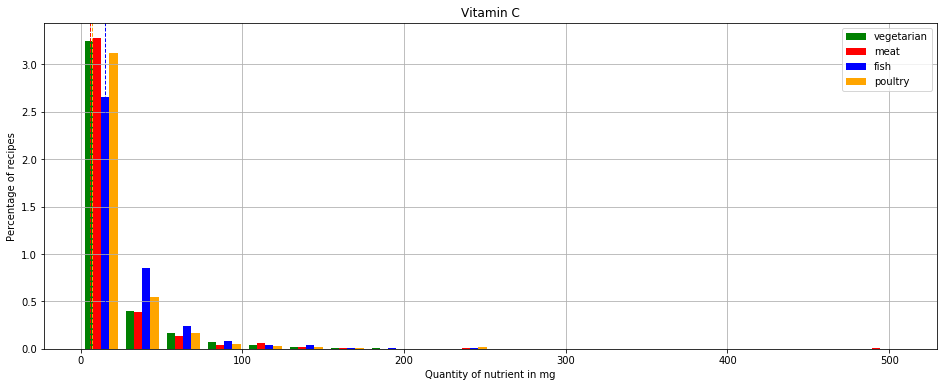

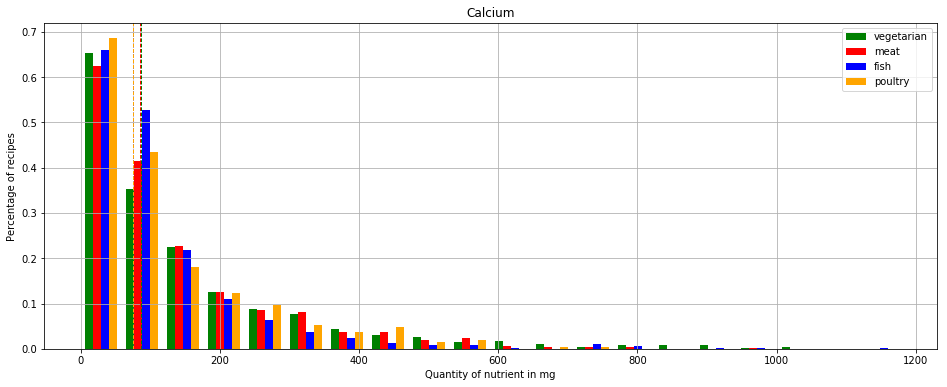

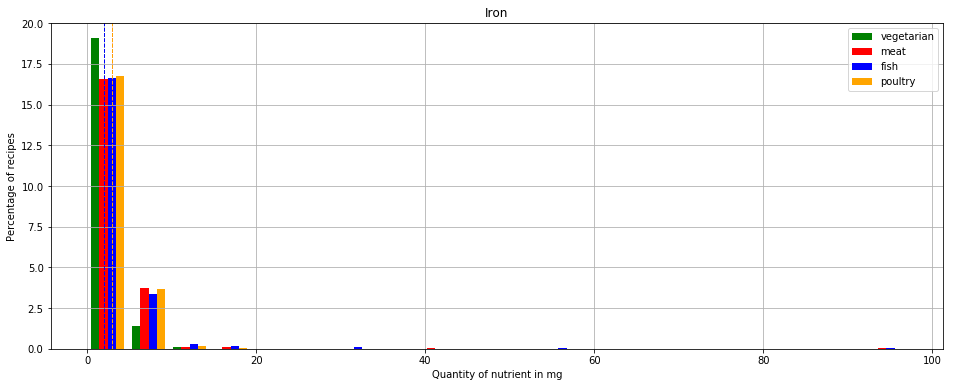

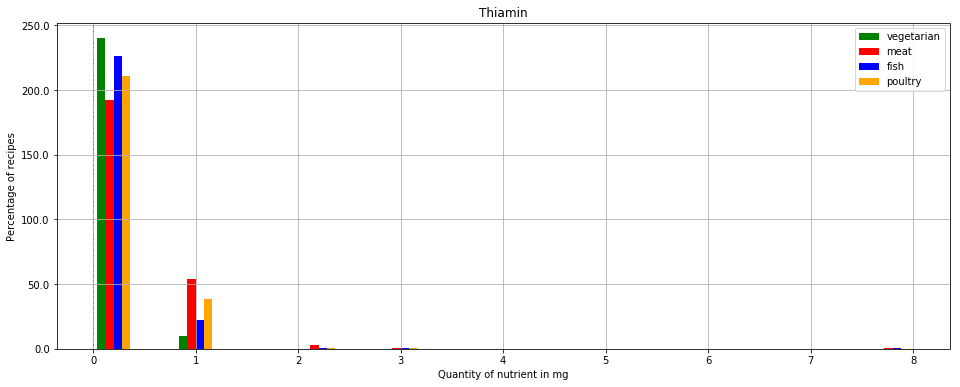

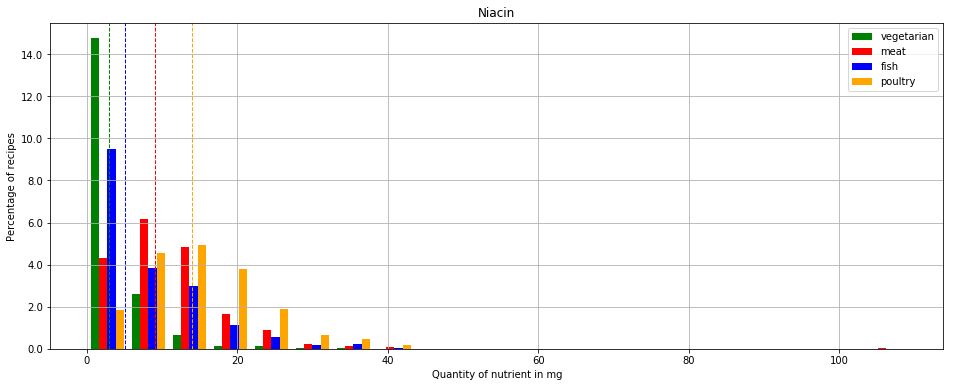

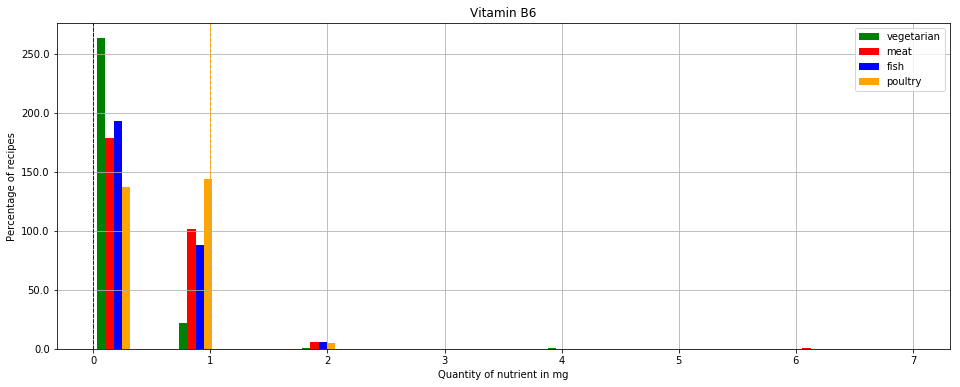

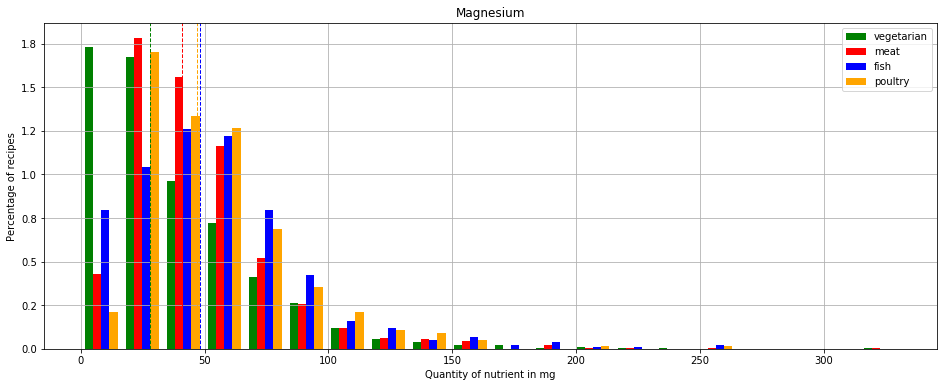

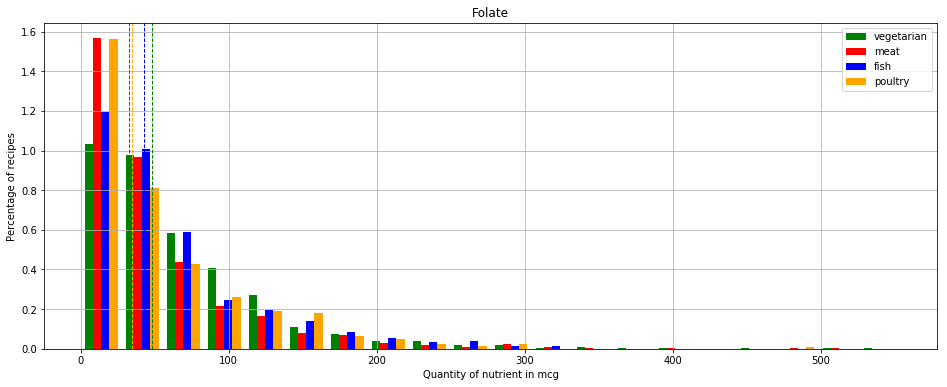

In [41]:
nutrientList = list(poultry_nutrients.nutrient.unique())
nutrientUnits = ['g', 'g', 'mg', 'mg', 'mg', 'g', 'g', 'g', 'g', 'IU', 'mg', 'mg', 'mg', 'mg', 'mg', 'mg', 'mg',
                 'mcg']
nutrientUnits_df = pd.DataFrame([nutrientList, nutrientUnits]).T
nutrientUnits_df.columns=['nutrient', 'unit']

for index,row in nutrientUnits_df.iterrows():
    nutrients_histograms(row['nutrient'], row['unit'], nutrients_dfs)

These distributions let us compare meal types, mostly by looking at medians which are dotted lines.